In [1]:
# Make imports and define constants

import warnings
import chembl_querries
import constants
import numpy as np
import polars as pl
import joblib
import matplotlib.pyplot as plt
import constants
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from preprocess_data import preprocess_bioactivity_data
from get_chembl_data import *

BIOACTIVITIES_CSV = f"{constants.DATA_FOLDER}/chembl_gpcr_bioactivities.csv"
PROCESSED_BIOACTIVITIES = f"{constants.DATA_FOLDER}/chembl_gpcr.parquet"
MODEL_SAVE_PATH = f"{constants.DATA_FOLDER}/standard_value_predictor.pkl"

In [ ]:
# Fetch data and save it to a csv file

querry = chembl_querries.GET_UNIPROT_BIOACTIVITES_FOR_GPCR
run_chembl_querry(querry, BIOACTIVITIES_CSV)

In [2]:
# Preprocess the csv data and save it to a parquet file.

with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore')
    preprocess_bioactivity_data(BIOACTIVITIES_CSV, PROCESSED_BIOACTIVITIES)

In [ ]:
# Load the bioactivities parquet and split the data into training and test

def merge_and_pad(row, max_length):
    """
    Transform the 2D array into a 1D array and pad 
    the end with 0s until the maxium length is reached
    """
    merged = np.concatenate(row, axis=0)
    pad_width = max_length - merged.shape[0]
    if pad_width > 0:
        merged = np.pad(merged, (0, pad_width), mode='constant', constant_values=0)
    return merged


activities = pl.read_parquet(PROCESSED_BIOACTIVITIES)
encodings = activities["encoding"]
fingerprint = activities["fingerprint"].to_list()
label = activities.select(["pchembl_value"]).to_numpy().ravel()

max_length = max(len(row) for row in encodings) * 20 # compute maxium length, multiply by 20 since an AA encoding is of length 20

encodings_padded = np.array([merge_and_pad(row, max_length) for row in encodings])
features = np.hstack([fingerprint, encodings_padded])

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)

print("Max encoding length: ", max_length)
print("Train set size: ", len(y_train))
print("Test set size: ", len(y_test))

In [ ]:
# Train the model and save it
model = RandomForestRegressor(n_estimators=100, random_state=42, verbose=2, n_jobs=-1)
model.fit(X_train, y_train)
joblib.dump(model, MODEL_SAVE_PATH)
print("training done")

In [ ]:
# Load the saved model and predict on the test set

with open(MODEL_SAVE_PATH, "rb") as file:
    model = joblib.load(file)

y_pred = model.predict(X_test)

RMSE: 0.7540268583876738


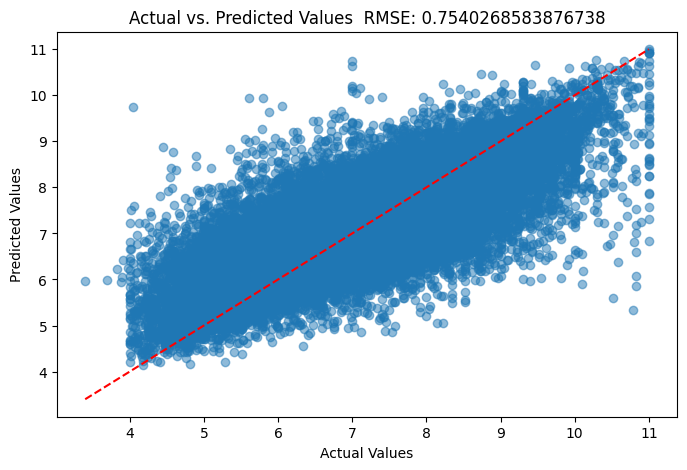

In [12]:
# Plot the model results

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed')  # y = x line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs. Predicted Values  RMSE: {rmse}")
plt.savefig(f"{constants.DATA_FOLDER}/RF_bioact_fp_regres.png")